<a href="https://colab.research.google.com/github/Xabz/Ensemble-Fall_Detection/blob/main/Gait_analysis_with_ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import glob
import shutil
import random

import time
import pickle

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K

!pip install tensorflow_addons
import tensorflow_addons as tfa

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve
import warnings

warnings.filterwarnings('ignore')

random.Random(12)
random.seed(12)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 6.0 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_x(file_name):
    temp = np.memmap(file_name, dtype='float32', mode='r')
    print(temp.shape)
    X = np.reshape(temp, [-1, 256, 6])
    return X



def load_y(file_name):
    n_classes = int(file_name[-1])
    temp = np.memmap(file_name, dtype='int8', mode='r')
    Y = np.reshape(temp, [-1, n_classes])
    return Y

In [9]:
#loading the train, test and validation data.
x_train = load_x('/content/drive/MyDrive/Dataset/SisFall_enhanced/Three Classes/x_train_3')
x_val = load_x('/content/drive/MyDrive/Dataset/SisFall_enhanced/Three Classes/x_val_3')
x_test = load_x('/content/drive/MyDrive/Dataset/SisFall_enhanced/Three Classes/x_test_3')


y_train = load_y('/content/drive/MyDrive/Dataset/SisFall_enhanced/Three Classes/y_train_3')
y_val = load_y('/content/drive/MyDrive/Dataset/SisFall_enhanced/Three Classes/y_val_3')
y_test = load_y('/content/drive/MyDrive/Dataset/SisFall_enhanced/Three Classes/y_test_3')

#reading the class weight
with open('/content/drive/MyDrive/Dataset/SisFall_enhanced/Three Classes/weights_3.txt') as f:
  lines = f.readlines()
class_weights = [float(x) for x in lines]
class_weights.reverse()

#convert the data in float32
x_train = np.asarray(x_train,dtype=np.float32)
x_val = np.asarray(x_val,dtype=np.float32)
x_test = np.asarray(x_test,dtype=np.float32)

y_train = np.asarray(y_train,dtype=np.float32)
y_val = np.asarray(y_val,dtype=np.float32)
y_test = np.asarray(y_test,dtype=np.float32)


print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)
class_weights

# y_train = np.asarray([np.argmax(x[:]) for x in y_train],dtype=np.float32)
# y_val = np.asarray([np.argmax(x[:]) for x in y_val],dtype=np.float32)
# y_test = np.asarray([np.argmax(x[:]) for x in y_test],dtype=np.float32)


(119609856,)
(31077888,)
(29005824,)
(77871, 256, 6) (77871, 3)
(20233, 256, 6) (20233, 3)
(18884, 256, 6) (18884, 3)


[1.0, 107.66810344827586, 33.48391420911528]

In [10]:
#calculate binary class weight
num_non_fall = np.where(np.asarray([np.argmax(x[:]) for x in y_train],dtype=np.float32)==0)[0].shape[0]
num_pre_fall = np.where(np.asarray([np.argmax(x[:]) for x in y_train],dtype=np.float32)==1)[0].shape[0]
num_fall = np.where(np.asarray([np.argmax(x[:]) for x in y_train],dtype=np.float32)==2)[0].shape[0]
print(num_non_fall,num_pre_fall,num_fall)

from sklearn.utils import class_weight
non_fall_w = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train[:,0]), y= y_train[:,0])
pre_fall_w = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train[:,1]), y= y_train[:,1])
fall_w = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train[:,2]), y= y_train[:,2])
non_fall_w = {0: non_fall_w[0], 1: non_fall_w[1]}
pre_fall_w = {0: pre_fall_w[0], 1: pre_fall_w[1]}
fall_w = {0: fall_w[0], 1: fall_w[1]}
print(non_fall_w,pre_fall_w,fall_w)



74937 696 2238
{0: 13.270449897750511, 1: 0.5195764442131391} {0: 0.5045092322643343, 1: 55.94181034482759} {0: 0.514795129110309, 1: 17.39745308310992}


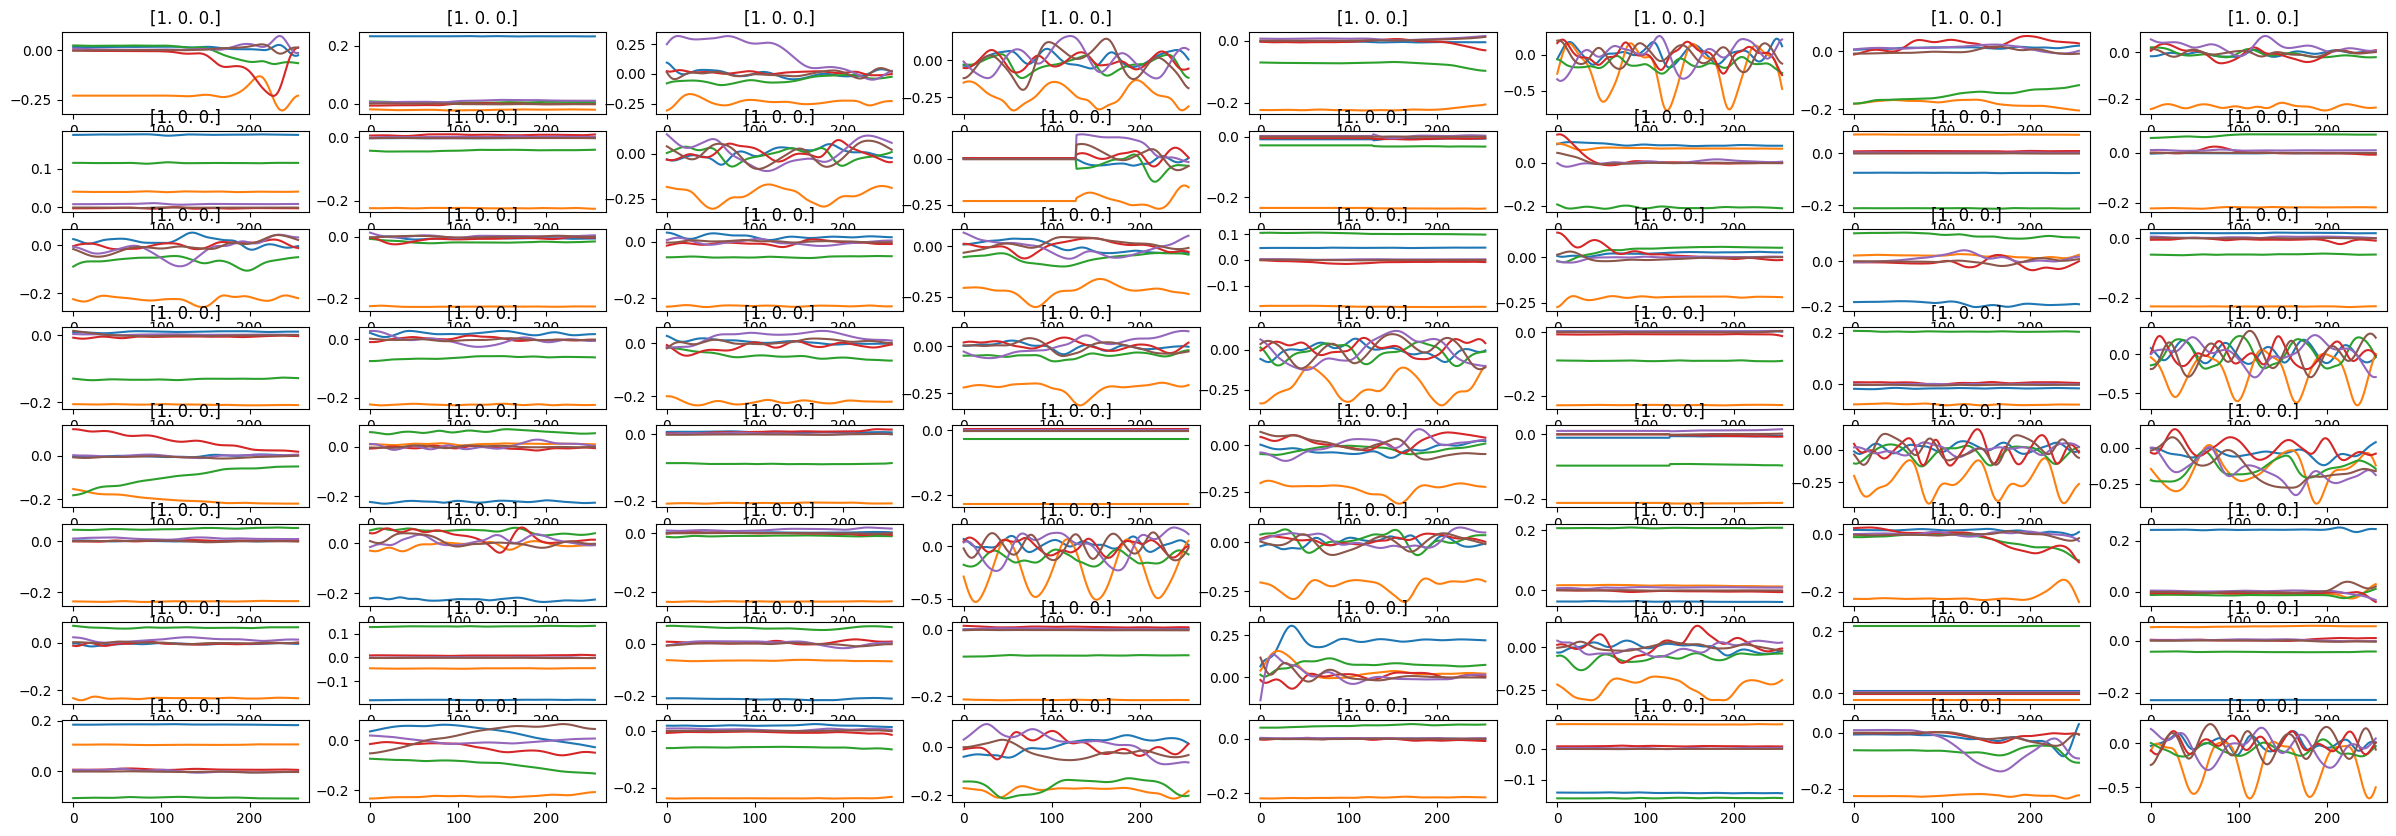

In [11]:
fig = plt.figure(figsize=(30,10))
ind = np.where(np.asarray([np.argmax(x[:]) for x in y_train],dtype=np.float32)==0)[0]
for ii in range(64):
    ax = fig.add_subplot(8,8,ii+1)
    ax.plot(x_train[ind[ii],:,:])
    ax.set_title(y_train[ind[ii]])

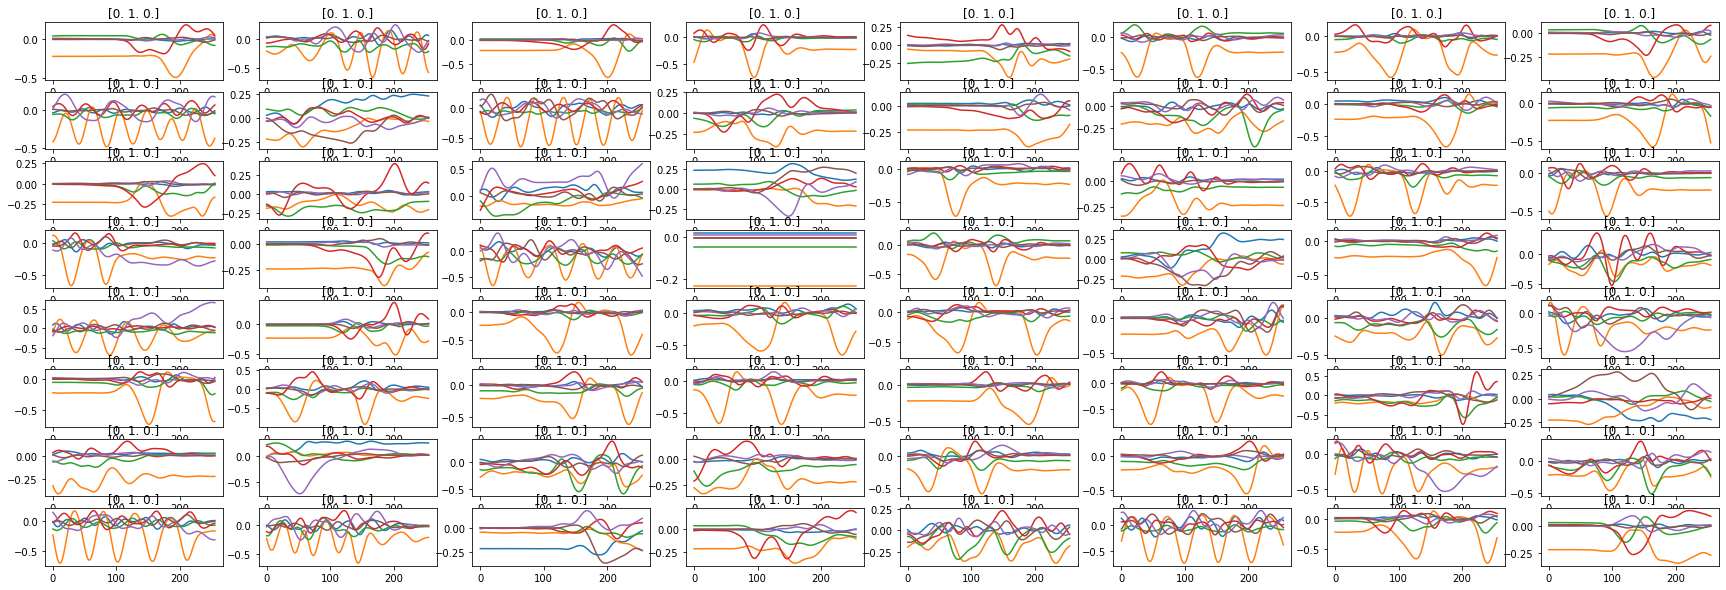

In [ ]:
fig = plt.figure(figsize=(30,10))
ind = np.where(np.asarray([np.argmax(x[:]) for x in y_train],dtype=np.float32)==1)[0]
for ii in range(64):
    ax = fig.add_subplot(8,8,ii+1)
    ax.plot(x_train[ind[ii],:,:])
    ax.set_title(y_train[ind[ii]])

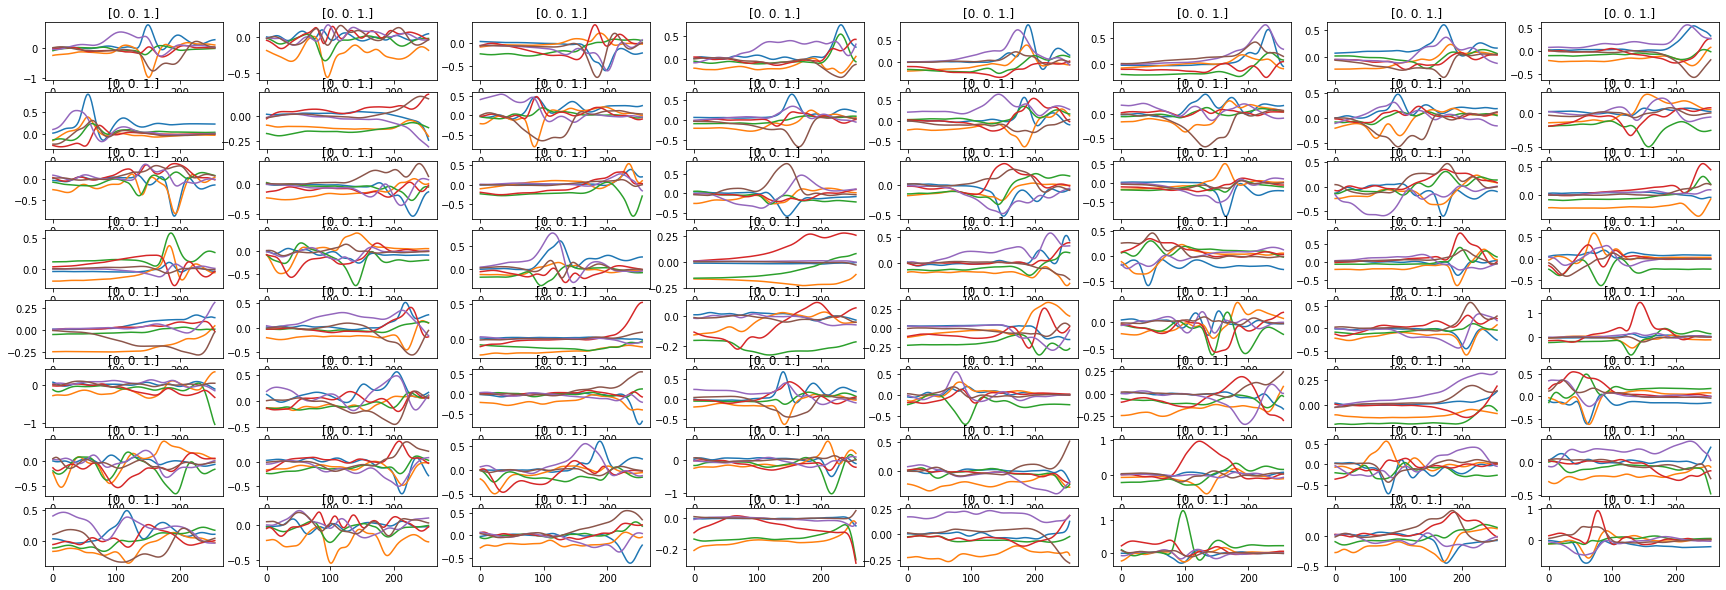

In [ ]:
fig = plt.figure(figsize=(30,10))
ind = np.where(np.asarray([np.argmax(x[:]) for x in y_train],dtype=np.float32)==2)[0]
for ii in range(64):
    ax = fig.add_subplot(8,8,ii+1)
    ax.plot(x_train[ind[ii],:,:])
    ax.set_title(y_train[ind[ii]])

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,X,y,batch_size,input_shape,p=None):
        self.X = X                    #input data
        self.y = y                    #input labels
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.total       = len(X)

        self.indexes     = np.arange(self.total)            #number of samples
        self.total_batch = self.total // self.batch_size    #number of batches in one iteration
        self.classes = len(np.unique(self.y))               #number of classes
        self.p = p                                          #augmentation probability
        self.rand = random.Random(12)
        random.seed(12)

        self.on_epoch_end()
    def axangle2mat(self,axis, angle, is_normalized=False):
        ''' Rotation matrix for rotation angle `angle` around `axis`
            Parameters
        ----------
        axis : 3 element sequence
          vector specifying axis for rotation.
        angle : scalar
          angle of rotation in radians.
        is_normalized : bool, optional
          True if `axis` is already normalized (has norm of 1).  Default False.
        Returns
        -------
        mat : array shape (3,3)
          rotation matrix for specified rotation
        Notes
        -----
        From: http://en.wikipedia.org/wiki/Rotation_matrix#Axis_and_angle
        '''
        x, y, z = axis
        if not is_normalized:
            n = np.math.sqrt(x*x + y*y + z*z)
            x = x/n
            y = y/n
            z = z/n
        c = np.math.cos(angle); s = np.math.sin(angle); C = 1-c
        xs = x*s;   ys = y*s;   zs = z*s
        xC = x*C;   yC = y*C;   zC = z*C
        xyC = x*yC; yzC = y*zC; zxC = z*xC
        return np.array([
                [ x*xC+c,   xyC-zs,   zxC+ys ],
                [ xyC+zs,   y*yC+c,   yzC-xs ],
                [ zxC-ys,   yzC+xs,   z*zC+c ]])

    def DA_Rotation(self,X,axis):
        axis = np.random.uniform(low=-10, high=10, size=axis)
        angle = np.random.uniform(low=-np.pi, high=np.pi)
        return np.append(np.matmul(X[:,:3] , self.axangle2mat(axis,angle)),np.matmul(X[:,3:] , self.axangle2mat(axis,angle)),axis=1)

    def DA_Jitter(self,X, sigma=0.002):#sigma = standard deviation of noise
        myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
        return X+myNoise

    def DA_Scaling(self,X, sigma=0.1): #sigma = STD of the zoom-in/out factor
        scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
        myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
        return X*myNoise

    def augment(self,x):
            w = np.random.choice(['R','S','J'],p = [0.6,0.3,0.1])
            if w =='R':
                return self.DA_Rotation(x,axis=3) #Rotation
            elif w== 'S':
                return self.DA_Scaling(x)         #scaling/zoom in-out
            else:
                return self.DA_Jitter(x)          #adding noise

    def Augmentation(self,x_train,y_train):
        index = np.asarray(np.where(np.asarray([np.argmax(x[:]) for x in y_train],dtype=np.float32)>=1))[0]

        # for i in index:
        for i in range(x_train.shape[0]):
            x = x_train[i]
            y = y_train[i]
            if self._make_choice():
              x_train[i] = self.augment(x)
        return x_train,y_train

    def _make_choice(self, p=None):
        w = [0.5, 0.5]
        if p is not None:
            w = [p, 1-p]
        return self.rand.choices([True, False], weights=w)[0]

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


    def __len__(self):
        return int(self.total // self.batch_size)


    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        if self.p:
            data,label = self.Augmentation(self.X[indexes], self.y[indexes])
            # return data,label
            return data,[label[:,0],label[:,1],label[:,2]]

        # return self.X[indexes], [self.y[indexes,0],self.y[indexes,1],self.y[indexes,2]]
        return self.X[indexes],self.y[indexes]



In [ ]:
from sklearn.metrics import classification_report
class MyLogger(tf.keras.callbacks.Callback):
    def __init__(self, n=None, validation_data=None,savepath=None,save_model=True,AE=None):
        self.n = n   # print loss & acc every n epochs
        if validation_data != None:
            self.x_val, self.y_val = validation_data
        self.start_time = time.time()
        self.start_epoch = 0
        self.savepath=savepath
        self.save_model = save_model
        self.AE = AE

        self.savelog = {'Epoch': [], 'Loss': [], 'Confusion_metric' : []}

        if self.savepath != None:
            self.logpath = os.path.join(self.savepath, 'log.pickle')
            self.opti_path = os.path.join(self.savepath, 'optimizer.pkl')
            self.modelpath = os.path.join(self.savepath, 'model_weights.h5')
        # Creating save paths
        if self.savepath != None and os.path.exists(self.savepath) == False:
            os.makedirs(self.savepath)
        # Loading previous data if found
        if self.savepath != None and os.path.exists(self.logpath):
            with open(self.logpath, 'rb') as f:
                self.savelog = pickle.load(f)
            print('Previous log loaded, starting epoch:', self.savelog['Epoch'][-1])
            self.start_epoch = self.savelog['Epoch'][-1]




    def on_epoch_end(self, epoch, logs={}):

        self.start_epoch +=1
        if self.start_epoch % self.n != 0 and self.start_epoch != 1: return

        self.start_time = time.time()

        cm = self._evaluate(self.y_val)

        ep_time = time.time() - self.start_time
        print(f"\rEpoch {self.start_epoch}: Time:{ep_time:.1f}",
              end='\n')
        print(f" {cm} ",end='\n')



        self._saveLog(self.start_epoch, logs['loss'], cm)

        if self.savepath != None:
            print(f'Saving model,, ')
            with open(self.logpath, 'wb') as f:
                pickle.dump(self.savelog, f)
            if self.save_model:
                self.model.save_weights(filepath=self.modelpath, overwrite=True, )

                symbolic_weights = getattr(self.model.optimizer, 'weights')
                weight_values = K.batch_get_value(symbolic_weights)
                with open(self.opti_path, 'wb') as f:
                    pickle.dump(weight_values, f)



    def _saveLog(self, epoch,loss, cm):
        self.savelog['Epoch'].append(epoch)
        self.savelog['Loss'].append(loss)
        self.savelog['Confusion_metric'].append(cm)


        # self.savelog['ACC'].append(acc)




    def _evaluate(self,y_val):
        outs = self.AE.predict(self.x_val)
        # print(outs)
        # outs = np.transpose(np.squeeze(np.asarray(outs))).shape
        # print(outs[0].shape)
        # outs = tf.nn.softmax(outs)
        # print(outs)
        cm = tf.math.confusion_matrix(np.argmax(y_val,axis=1), np.argmax(outs,axis=1))



        return cm

In [13]:
from sklearn.metrics import classification_report
class MyLogger(tf.keras.callbacks.Callback):
    def __init__(self, n=None, validation_data=None,savepath=None,save_model=True,AE=None):
        self.n = n   # print loss & acc every n epochs
        if validation_data != None:
            self.x_val, self.y_val = validation_data
        self.start_time = time.time()
        self.start_epoch = 0
        self.savepath=savepath
        self.save_model = save_model
        self.AE = AE

        self.savelog = {'Epoch': [], 'Loss': [], 'Confusion_metric' : []}

        if self.savepath != None:
            self.logpath = os.path.join(self.savepath, 'log.pickle')
            self.opti_path = os.path.join(self.savepath, 'optimizer.pkl')
            self.modelpath = os.path.join(self.savepath, 'model_weights.h5')
        # Creating save paths
        if self.savepath != None and os.path.exists(self.savepath) == False:
            os.makedirs(self.savepath)
        # Loading previous data if found
        if self.savepath != None and os.path.exists(self.logpath):
            with open(self.logpath, 'rb') as f:
                self.savelog = pickle.load(f)
            print('Previous log loaded, starting epoch:', self.savelog['Epoch'][-1])
            self.start_epoch = self.savelog['Epoch'][-1]




    def on_epoch_end(self, epoch, logs={}):

        self.start_epoch +=1
        if self.start_epoch % self.n != 0 and self.start_epoch != 1: return

        self.start_time = time.time()

        nonfall_sensitivity = logs['val_non-fall_true_positives']/(logs['val_non-fall_true_positives']+logs['val_non-fall_false_negatives'])
        prefall_sensitivity = logs['val_pre-fall_true_positives']/(logs['val_pre-fall_true_positives']+logs['val_pre-fall_false_negatives'])
        fall_sensitivity = logs['val_fall_true_positives']/(logs['val_fall_true_positives']+logs['val_fall_false_negatives'])

        nonfall_specificity = logs['val_non-fall_true_negatives']/(logs['val_non-fall_true_negatives']+logs['val_non-fall_false_positives'])
        prefall_specificity = logs['val_pre-fall_true_negatives']/(logs['val_pre-fall_true_negatives']+logs['val_pre-fall_false_positives'])
        fall_specificity = logs['val_fall_true_negatives']/(logs['val_fall_true_negatives']+logs['val_fall_false_positives'])

        nonfall_accuracy = (logs['val_non-fall_true_positives']+logs['val_non-fall_true_negatives'])/(logs['val_non-fall_true_positives']+logs['val_non-fall_true_negatives']+logs['val_non-fall_false_negatives']+logs['val_non-fall_false_positives'])
        prefall_accuracy = (logs['val_pre-fall_true_positives']+logs['val_pre-fall_true_negatives'])/(logs['val_pre-fall_true_positives']+logs['val_pre-fall_true_negatives']+logs['val_pre-fall_false_negatives']+logs['val_pre-fall_false_positives'])
        fall_accuracy = (logs['val_fall_true_positives']+logs['val_fall_true_negatives'])/(logs['val_fall_true_positives']+logs['val_fall_true_negatives']+logs['val_fall_false_negatives']+logs['val_fall_false_positives'])

        ep_time = time.time() - self.start_time
        print(f"\rEpoch {self.start_epoch}: Time:{ep_time:.1f}",
              end='\n')
        # print(f" {cm} ",end='\n')
        print(f"\rSensitivity: Non-fall: {nonfall_sensitivity}, Pre-fall: {prefall_sensitivity}, Fall: {fall_sensitivity}",end='\n')
        print(f"\rSpecificity: Non-fall: {nonfall_specificity}, Pre-fall: {prefall_specificity}, Fall: {fall_specificity}",end='\n')
        print(f"\rAccuracy: Non-fall: {nonfall_accuracy}, Pre-fall: {prefall_accuracy}, Fall: {fall_accuracy}",end='\n')


        # self._saveLog(self.start_epoch, logs['loss'], cm)

        if self.savepath != None:
            print(f'Saving model,, ')
            with open(self.logpath, 'wb') as f:
                pickle.dump(self.savelog, f)
            if self.save_model:
                self.model.save_weights(filepath=self.modelpath, overwrite=True, )

                symbolic_weights = getattr(self.model.optimizer, 'weights')
                weight_values = K.batch_get_value(symbolic_weights)
                with open(self.opti_path, 'wb') as f:
                    pickle.dump(weight_values, f)



    def _saveLog(self, epoch,loss, cm):
        self.savelog['Epoch'].append(epoch)
        self.savelog['Loss'].append(loss)
        self.savelog['Confusion_metric'].append(cm)


        # self.savelog['ACC'].append(acc)




    def _evaluate(self,y_val):
        outs = self.AE.predict(self.x_val)
        # print(outs)
        outs = np.transpose(np.squeeze(np.asarray(outs))).shape
        # print(outs[0].shape)
        outs = tf.nn.softmax(outs)
        # print(outs)
        cm = tf.math.confusion_matrix(np.argmax(y_val,axis=1), np.argmax(outs,axis=1))



        return cm

In [14]:
  base_dir = '/content/drive/MyDrive/Research_Result/Fall_Detection'
dataset = 'SISFALL'
loss = 'WCE'
augmented = True
architecture = 'Ensemble'
batch_size = 128
learning_rate = 0.0005

pname = f"3_classes/{dataset}_{loss}_{augmented}_classweight/{batch_size}_{architecture}"

# ResNet type Ensemble CNN-LSTM

In [ ]:

def res_identity(x, filters):
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block
  f1, f2 = filters

  #first block
  #kernel_regularizer=tf.keras.regularizers.l2(0.001)

  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.SeparableConv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  #second block # bottleneck (but size kept same with padding)
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.SeparableConv1D(f1, kernel_size=3, strides=1, padding='same', )(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # third block activation used after adding the input
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.SeparableConv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # x = Activation(activations.relu)(x)

  # add the input
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x


def conv_skip(x, filters):
  '''
  here the input size changes'''
  x_skip = x
  f1, f2 = filters

  # first block
  x = tf.keras.layers.SeparableConv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  # when s = 2 then it is like downsizing the feature map
  x = tf.keras.layers.BatchNormalization()(x)


  # second block
  # x = tf.keras.layers.SeparableConv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  #third block
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.SeparableConv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=3,strides=2)(x)
  x = tf.keras.layers.ZeroPadding1D(padding=(0,1))(x)

  # shortcut
  x_skip = tf.keras.layers.Conv1D(f1, kernel_size=1, strides=2, padding='valid')(x_skip)
  x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x


def maxpool_skip(x, filters):
  '''
  here the input size changes'''


  x_skip = x # this will be used for addition with the residual block
  f1, f2 = filters

  #first block
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.SeparableConv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # third block activation used after adding the input

  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.SeparableConv1D(f1, kernel_size=3, strides=1, padding='same', )(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.MaxPooling1D(pool_size = 3,strides=2)(x)
  x = tf.keras.layers.ZeroPadding1D(padding=(0,1))(x)

  # shortcut
  x_skip = tf.keras.layers.Conv1D(f1, kernel_size=1, strides=2, padding='valid')(x_skip)
  x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add
  x = tf.keras.layers.Add()([x, x_skip])
  x = tf.keras.layers.SeparableConv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x

def buildAE(input_shape,classes,learning_rate,class_weights):

    input = tf.keras.Input(shape=input_shape)
    # x = tf.keras.layers.ZeroPadding1D(padding=(2,2))(input)
    x = tf.keras.layers.Conv1D(16, kernel_size=3, strides=1,padding='same',)(input)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(x)

    x = conv_skip(x ,filters=(16,16))
    for i in range(3):
        x = res_identity(x,filters=(16,16))
    x = maxpool_skip(x,filters=(16,16))


    class_name = ['non-fall','pre-fall','fall']
    ens = []
    for i in range(classes):
        # res = tf.keras.layers.BatchNormalization()(x)
        res = tf.keras.layers.Dropout(0.5)(x)
        res = tf.keras.layers.LSTM(units=16,activation='tanh',return_sequences=True)(res)
        res = tf.keras.layers.BatchNormalization()(res)
        res = tf.keras.layers.Dropout(0.5)(res)
        res = tf.keras.layers.LSTM(units=16,activation='tanh')(res)
        # res = tf.keras.layers.Dropout(0.5)(res)

        res = tf.keras.layers.Dense(units=16)(res)
        res = tf.keras.layers.Dense(units=1,activation='sigmoid',name=class_name[i])(res)
        ens.append(res)

    # x = tf.keras.layers.Concatenate()(ens)
    # output = tf.keras.layers.Activation('softmax')(x)
    # model = tf.keras.Model(input,output)

    model = tf.keras.Model(input,ens)

    loss_weights = {
    'non-fall': class_weights[0],  # no weighting
    'pre-fall': class_weights[1],  # double weight
    'fall': class_weights[2]   # half weight
    }



    print('Params', model.count_params())
    model.compile(loss = {'non-fall': tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          'pre-fall': tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          'fall': tf.keras.losses.BinaryCrossentropy(from_logits=True)
                          },
                  loss_weights = loss_weights,
                  # loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives(),
                           tf.keras.metrics.BinaryAccuracy(),],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


    model.summary()

    return model
# model = buildAE((256,6),3,0.0005)
# tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
# SeparableConv1D / swish/ LSTM
strat = tf.distribute.MirroredStrategy()
global AE
tf.keras.backend.clear_session()




loaded = False
save_dir = os.path.join(base_dir, pname)
opti_dir = os.path.join(save_dir,'optimizer.pkl')

dg = DataGenerator(x_train,y_train,batch_size=batch_size,input_shape=x_train.shape[1:],p=augmented)

# class_weight = {0: class_weight[0], 1: class_weight[1]}


# if os.path.exists(os.path.join(save_dir, 'model_weights.h5')):
#     try:
#         print('Previous weights found, building model')
#         with strat.scope():
#             model = buildAE(x_train.shape[1:],y_train.shape[-1])
#             print('Loading weights')
#             model.load_weights(os.path.join(save_dir, 'model_weights.h5'))
#         loaded = True
#     except Exception as e:
#         print(str(e))
#         pass

#     print('loading optimizer')
#     grad_vars = model.trainable_weights
#     zero_grads = [tf.zeros_like(w) for w in grad_vars]
#     model.optimizer.apply_gradients(zip(zero_grads, grad_vars))
#     with open(opti_dir, 'rb') as f:
#       weight_values = pickle.load(f)
#     model.optimizer.set_weights(weight_values)


if not loaded:
    print('Initializing new model')
    with strat.scope():
        model = buildAE(x_train.shape[1:],y_train.shape[-1],learning_rate,class_weights)
    loaded = True

class_weights = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
log = MyLogger(n=1, validation_data=(x_test,y_test),savepath=None,save_model=False, AE=model)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0.00001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

def scheduler(epoch, lr):
  if epoch % 25==0:
    return lr * 0.5
  return lr

lr_schedular = tf.keras.callbacks.LearningRateScheduler(scheduler)

print('Starting model training')
# history= model.fit(dg, epochs=101, verbose=1, callbacks=[log,reduce_lr,early_stop],validation_data=(x_test,y_test),class_weight=class_weights)
history= model.fit(dg, epochs=101, verbose=1, callbacks=[log,reduce_lr,early_stop],validation_data=(x_test,[y_test[:,0],y_test[:,1],y_test[:,2]]))#,class_weight=class_weights)

Initializing new model
Params 20147
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 6)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 16)      304         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 16)     64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 256, 16)      0    

591/591 [==============================] - 9s 14ms/step


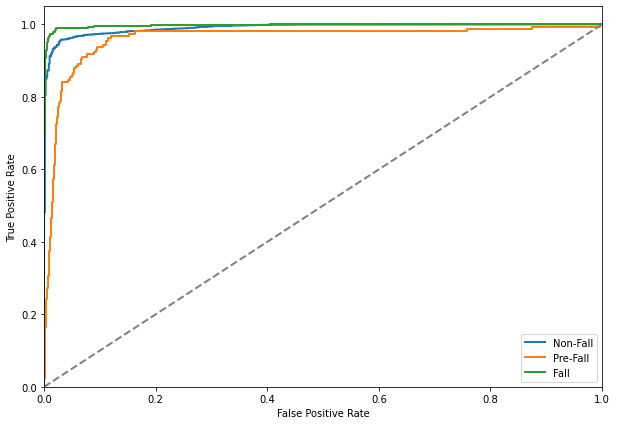

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assume that we have a multi-class classification problem with 3 classes
# y_true = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
# y_pred = np.array([[0.8, 0.1, 0.1], [0.2, 0.6, 0.2], [0.3, 0.4, 0.3],
#                    [0.9, 0.05, 0.05], [0.2, 0.7, 0.1], [0.1, 0.2, 0.7],
#                    [0.7, 0.2, 0.1], [0.3, 0.5, 0.2], [0.4, 0.3, 0.3]])

y_true = np.argmax(y_test,axis=1)
y_pred = model.predict(x_test)

# Calculate the number of classes
num_classes = y_pred.shape[1]

# Iterate over each class and calculate the ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    # Treat the current class as positive and all other classes as negative
    y_true_class = (y_true == i).astype(int)
    y_pred_class = y_pred[:, i]

    # Calculate the false positive and true positive rates for each possible threshold
    fpr[i], tpr[i], _ = roc_curve(y_true_class, y_pred_class)

    # Calculate the area under the ROC curve for the current class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class versus the rest
# plt.figure()
plt.figure(figsize=(10,7))
lw = 2
class_name = ['Non-Fall','Pre-Fall','Fall']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label=f'{class_name[i]}')

plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


633/633 [==============================] - 9s 14ms/step


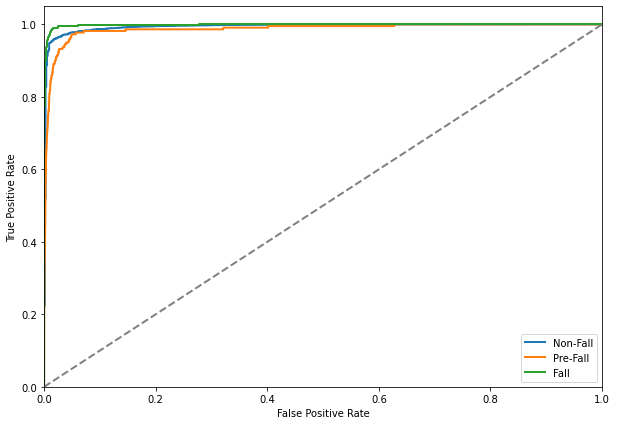

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assume that we have a multi-class classification problem with 3 classes
# y_true = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
# y_pred = np.array([[0.8, 0.1, 0.1], [0.2, 0.6, 0.2], [0.3, 0.4, 0.3],
#                    [0.9, 0.05, 0.05], [0.2, 0.7, 0.1], [0.1, 0.2, 0.7],
#                    [0.7, 0.2, 0.1], [0.3, 0.5, 0.2], [0.4, 0.3, 0.3]])

y_true = np.argmax(y_val,axis=1)
y_pred = model.predict(x_val)

# Calculate the number of classes
num_classes = y_pred.shape[1]

# Iterate over each class and calculate the ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    # Treat the current class as positive and all other classes as negative
    y_true_class = (y_true == i).astype(int)
    y_pred_class = y_pred[:, i]

    # Calculate the false positive and true positive rates for each possible threshold
    fpr[i], tpr[i], _ = roc_curve(y_true_class, y_pred_class)

    # Calculate the area under the ROC curve for the current class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class versus the rest
# plt.figure()
plt.figure(figsize=(10,7))
lw = 2
class_name = ['Non-Fall','Pre-Fall','Fall']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label=f'{class_name[i]}')

plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


In [ ]:
outs = model.predict(x_val)

cm = tf.math.confusion_matrix(np.argmax(y_val,axis=1), np.argmax(outs,axis=1))
cm
# 19463

NameError: ignored

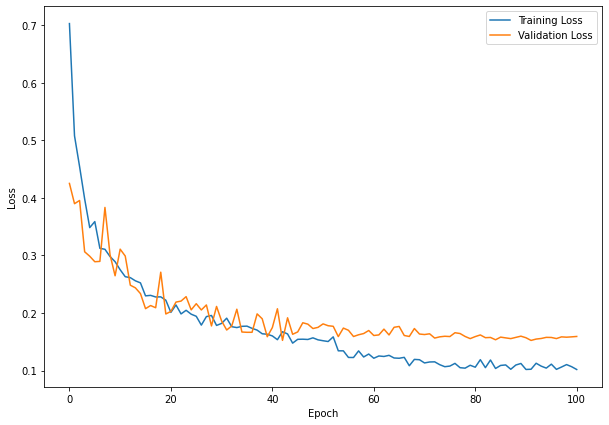

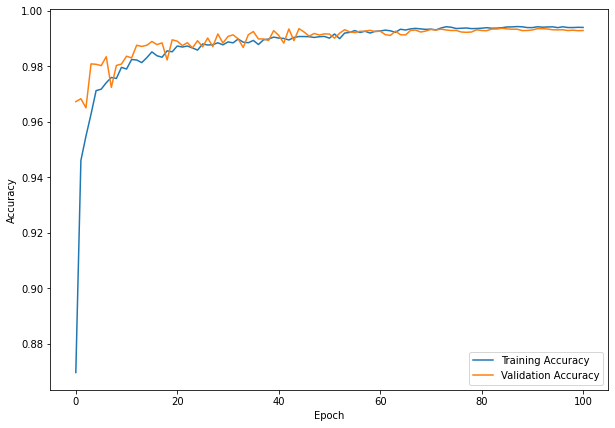

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10,7))
plt.plot(history.history['auc'], label='Training Accuracy')
plt.plot(history.history['val_auc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.load_weights('Ensemble_weight.h5')

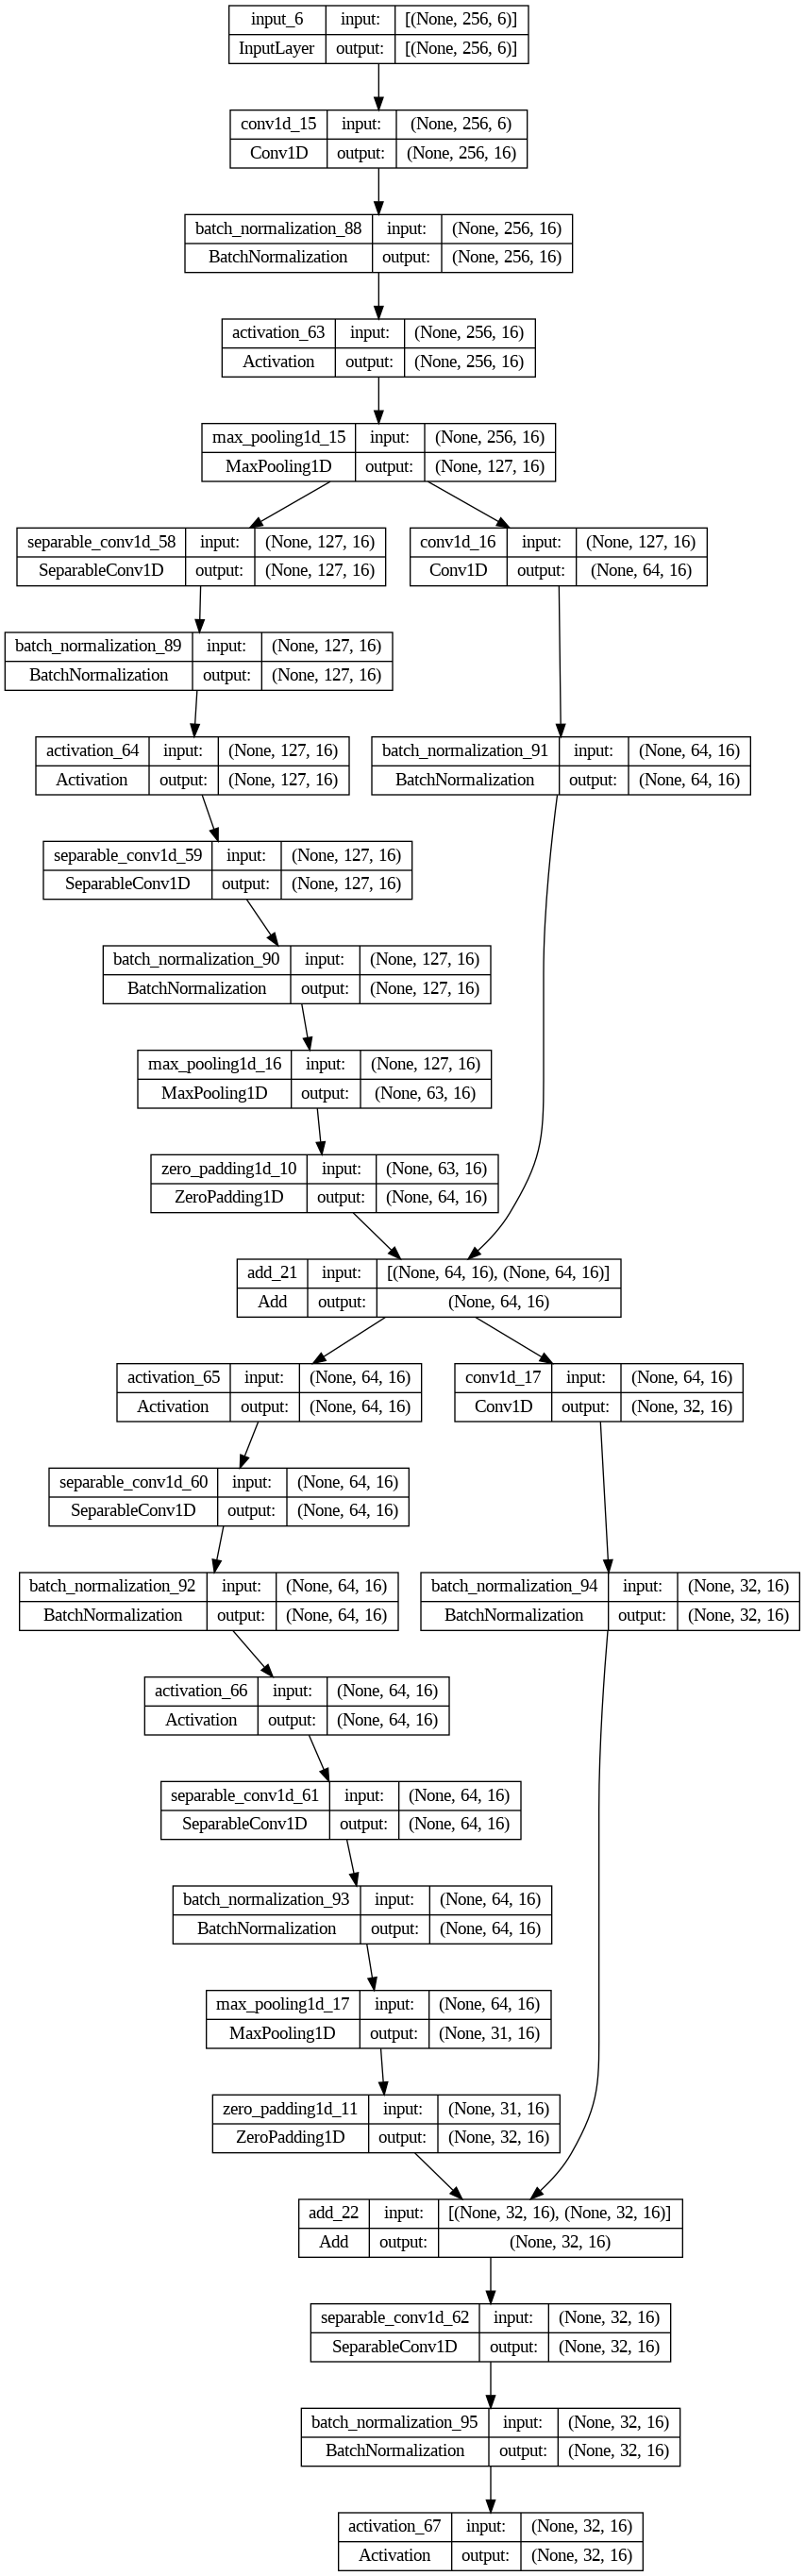

In [ ]:
submodel = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-24].output)
tf.keras.utils.plot_model(submodel,show_shapes=True)

In [ ]:
y_pred = submodel.predict(x_val)
y_pred.shape

633/633 [==============================] - 14s 6ms/step


(20233, 32, 16)

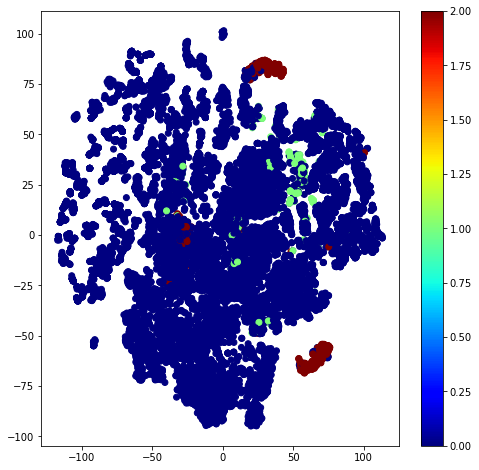

In [ ]:
from sklearn.manifold import TSNE

# Assuming you have an array called "embeddings" with shape (n_samples, embedding_dim)
# and an array called "labels" with shape (n_samples,) containing the labels for each sample
y_pred = y_pred.reshape(y_pred.shape[0], -1)
# Compute t-SNE embedding of the high-dimensional space
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embeddings_2d = tsne.fit_transform(y_pred)

# Create a scatter plot of the embeddings colored by the labels
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=np.argmax(y_val,axis=1), cmap='jet')
plt.colorbar()
plt.show()

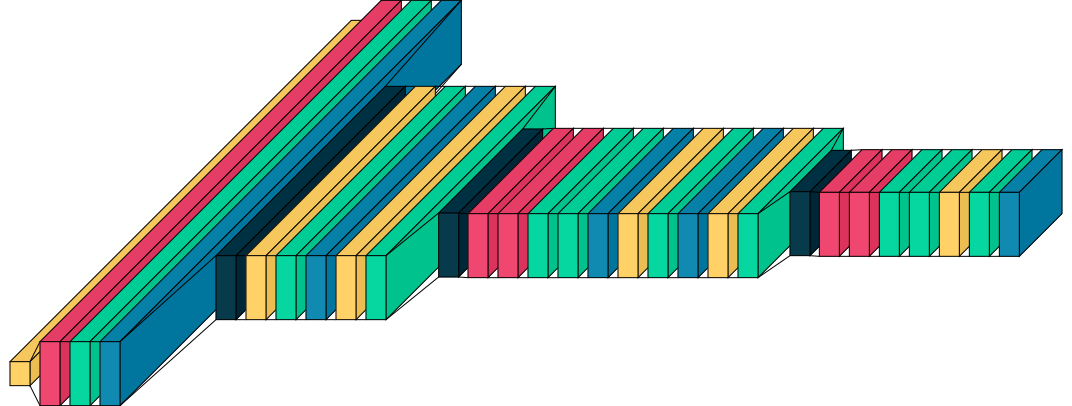

In [ ]:
# !pip install git+https://github.com/paulgavrikov/visualkeras

# import visualkeras

# model = ...

# visualkeras.layered_view(submodel).show() # display using your system viewer
# visualkeras.layered_view(submodel, to_file='output.png') # write to disk
visualkeras.layered_view(submodel, to_file='output.png').show() # write and show

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
model.save('my_model.h5')